(content:references:tabular_part3)=
# Catalogue Data Part 1: *Mixed Data Types*

***Author: Marc Hon***

[](content:references:tabular_part2) presented how we may determine the ages of stars using stellar models. The ages of stars are inferred -- there is no way of determining them independently of models. 


There may exist a small sample of stars for which their ages can be inferred to a relatively higher precision due to the availability of multiple types of measurements, including spectroscopy, asteroseismology, and photometry. These stars are often used as a benchmark or training set for new machine learning models that infer the ages of other stars around our Galaxy.

In this chapter, we will explore the use of Gradient Boosted Trees to infer the ages of stars within the disk of the Milky Way. These are stars observed by the [APOKASC](https://iopscience.iop.org/article/10.3847/1538-4365/ad9fef/pdf) collaboration, in which asteroseismic measurements are provided by NASA's [*Kepler*](https://science.nasa.gov/mission/kepler/) mission, and high resolution spectroscopy provided by [APOGEE](https://www.sdss4.org/surveys/apogee/) (Apache Point Observatory Galactic Evolution Experiment).

In [1]:
import os
import yaml
import numpy as np
import pandas as pd
import seaborn as sns
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

from pathlib import Path
from astropy.io import fits
from matplotlib import cm
from matplotlib.colors import Normalize
from astropy import coordinates as coords
from scipy.stats import truncnorm, norm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

plt.style.use('science'); fs=15

data_folder_path = Path.cwd().resolve().parent.parent / 'ml_astro' / 'chapter3' / 'data'

agb_grid = pd.read_csv(str(data_folder_path) + '/AGB_grid.csv').set_index(['initial_mass', 'initial_met', 'step'])

## Dataset of Red Giant Star Properties

In [2]:
apo = pd.read_csv(str(data_folder_path) + '/APOKASC3_EvAGB.csv').rename(columns={'[Fe/H]': 'Fe/H',
                                                                                 '[a/Fe]': 'a/Fe',
                                                                                'Adopted_Age': 'Age',
                                                                                'logg-Seis': 'logg'})
apo

,KIC,EV,a/Fe,Teff,Fe/H,logg,alphaCat,Age
0,893214,1,0.0815,4718.9233,-0.2617,2.5146,Apoor,2.8815
1,1026309,1,-0.0295,4479.2246,0.1609,2.1176,Apoor,0.5842
2,1026452,2,0.0658,4910.6035,-0.2652,2.4510,Apoor,2.6495
3,1027110,1,0.2615,4194.4375,-0.3017,1.6949,Arich,9.0694
4,1027337,1,0.0354,4621.9960,0.2081,2.7732,Apoor,5.8519
...,...,...,...,...,...,...,...,...
11442,12785401,1,0.0451,4319.3400,0.2022,2.0897,Apoor,15.6194
11443,12833300,2,0.0741,4592.0396,0.0764,2.3738,Arich,8.1186
11444,12884116,1,0.0762,4645.3340,-0.0631,2.6086,Apoor,7.6715
11445,12884930,2,0.0384,4912.1650,-0.1505,2.4933,Apoor,3.2902


The dataset comprises over 10,000 red giant stars with the following columns for each star:

- `KIC`: **K**epler **I**nput **C**atalog Identifier
- `Teff`: Stellar effective temperature $T_{\mathrm{eff}}$
- `Fe/H`: Surface global metallicity [Fe/H] in cgs units
- `logg`: Surface gravity in cgs units
- `Age`: Stellar age in units of Gyr


> **The goal of this exercise is to train a machine learning model that may predict stellar ages with the information at hand.**


However, the dataset also contains columns with categorical data, as described by the following:


### Evolutionary state, `EV`

Giant stars undergo a complex evolution of their stellar interiors, as shown in the schematic below


```{figure} images/giant_crossection.png
---
height: 300px
width: 800px
name: giantcross_section
---
Schematic of cross-sections for a giant star. Labelled as 'sub/red giant' is a less-evolved giant star that still burns hydrogen in a shell within its interior. Meanwhile, 'red clump' stars are **more evolved** and have begun burning helium within their cores. Adapted from [Bellinger et al. (2018)](https://arxiv.org/abs/1808.06649).

```

Despite having drastically different interiors, hydrogen- and helium- burning giant stars may possess very similar surface properties (e.g., $T_{\mathrm{eff}}$ and $\log (g)$), shown by both models and observed data:


/tmp/ipykernel_13043/1324314857.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


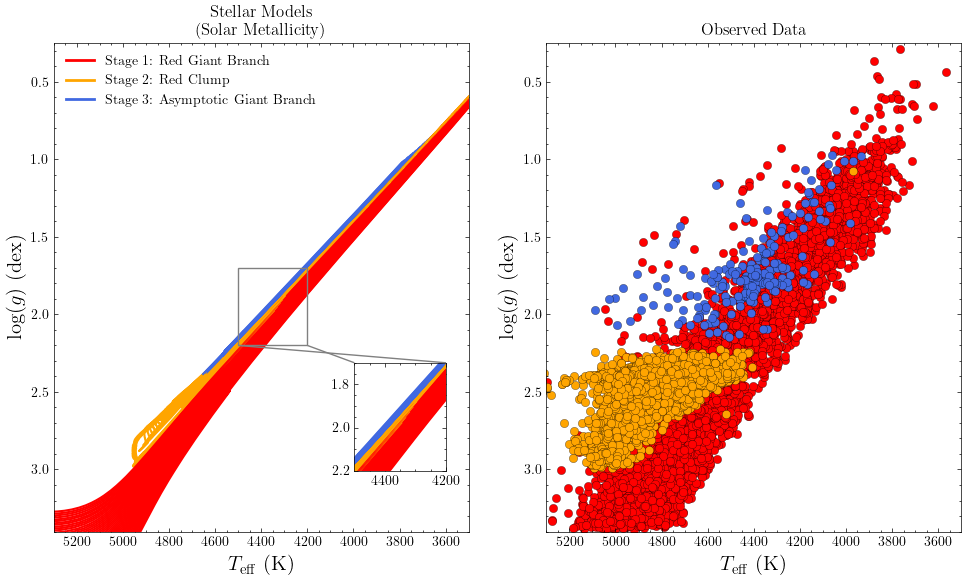

In [71]:
def plot_kiel(f_):
    fig = plt.figure(figsize=(10,6))
    ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
    
    ax1a = inset_axes(ax1, width="47%", height=
                      "47%", loc='center',
                      bbox_to_anchor=(0.6, 0, 0.47, 0.47),
                      bbox_transform=ax1.transAxes)

    s = np.unique(agb_grid.index.get_level_values('step').values)
    unique_mass_met = np.unique(np.column_stack((agb_grid.index.get_level_values('initial_mass').values,
                                                 agb_grid.index.get_level_values('initial_met').values)), axis=0)
    for row in unique_mass_met:
        if row[1] == f_:
            for ax in [ax1, ax1a]:
                ax.plot( 10**agb_grid.loc[(row[0], f_, s)]['teff'][agb_grid.loc[(row[0], f_, s)]['phase'] < 3],
                     agb_grid.loc[(row[0], f_, s)]['logg'][agb_grid.loc[(row[0], f_, s)]['phase'] < 3], 
                         color='red',
                    lw=1.5)
                ax.plot( 10**agb_grid.loc[(row[0], f_, s)]['teff'][agb_grid.loc[(row[0], f_, s)]['phase'] == 3],
                     agb_grid.loc[(row[0], f_, s)]['logg'][agb_grid.loc[(row[0], f_, s)]['phase'] == 3], 
                         color='orange',
                    lw=1.5)
                ax.plot( 10**agb_grid.loc[(row[0], f_, s)]['teff'][agb_grid.loc[(row[0], f_, s)]['phase'] == 4],
                     agb_grid.loc[(row[0], f_, s)]['logg'][agb_grid.loc[(row[0], f_, s)]['phase'] == 4], 
                         color='royalblue',
                    lw=1.5)
    
    ax1.plot([], [], lw=2, c='red', label='Stage 1: Red Giant Branch')
    ax1.plot([], [], lw=2, c='orange', label='Stage 2: Red Clump')
    ax1.plot([], [], lw=2, c='royalblue', label='Stage 3: Asymptotic Giant Branch')
    

#     ax1.indicate_inset_zoom(ax1a, edgecolor="black", zorder=999)
    mark_inset(ax1, ax1a, loc1=1, loc2=2, fc="none", ec="0.5", zorder=999)
    
    ax2.scatter(apo.Teff[apo.EV == 1], apo['logg'][apo.EV == 1], c='red', edgecolor='k', lw=0.2)
    ax2.scatter(apo.Teff[apo.EV == 2], apo['logg'][apo.EV == 2], c='orange', edgecolor='k', lw=0.2)
    ax2.scatter(apo.Teff[apo.EV == 3], apo['logg'][apo.EV == 3], c='royalblue', edgecolor='k', lw=0.2)

    
    for ax in [ax1, ax2]:
        ax.set_xlim(3500, 5300)
        ax.invert_xaxis()
        ax.invert_yaxis()
        ax.set_ylim(3.4, 0.25)
        ax.set_xlabel('$T_{\\mathrm{eff}}$ (K)', fontsize=fs)
        ax.set_ylabel('$\\log(g)$ (dex)', fontsize=fs)

    ax1.legend(prop={'size': fs-5})
    
    ax1a.invert_xaxis()
    ax1a.invert_yaxis()
    ax1a.set_xlim(4500, 4200)
    ax1a.set_ylim(2.2, 1.7)
    ax1.set_title('Stellar Models\n(Solar Metallicity)')
    ax2.set_title('Observed Data')

    plt.tight_layout()
    
init_metallicity = 0
plot_kiel(init_metallicity)

These different evolutionary stages are encapsulated by the `EV` parameter of the dataset, defined as the following:
- `EV = 1`: <span style="color: red">Red Giant Branch</span>, hydrogen-burning stage. It is the **first ascent** of giants up the "branch", where they swell to enormous sizes and develop a low surface gravity.

- `EV = 2`: <span style="color: orange">Red Clump</span>, helium-burning stage. Upon reaching the tip of the branch, the stars **ignite helium** in their core and develop a higher $\log (g)$.

- `EV = 3`: <span style="color: royalblue">Asymptotic Giant Branch</span>, helium-burning stage. Over time, red clump stars eventually begin the climb up the "branch" again towards lower $\log (g)$.


These stages occur **sequentially**, such that Stages 2 and 3 typically occur several Myr after Stage 1. However, as shown above, there exists significant overlap between stars in these stages based on their $T_{\mathrm{eff}}$ and $\log(g)$.

```{admonition} Interpreting Ages and Evolution
:class: danger

Given the following two stars:

- **Star A**: Stage 1, hydrogen-burning
- **Star B**: Stage 2, helium-burning

It is tempting to assign an older age to star B simply due to its later stage of evolution. **This is only true in general if both stars have the same mass and metallicity.** As shown in [](content:references:tabular_part2), the ages of stars are strongly sensitive to mass and metallicity, rather than evolution. Hence, it is entirely possible (and common!) -- that if Star A is lower in mass than Star B -- for Star A to be the older star between the two.
```

### Alpha enhancement, `alphaCat`


This parameter determines the level of enrichment of the star's surface with $\alpha$-elements like C, O, Mg, and Si. The level of enrichment is indicative of the membership of the star within particular stellar populations of the Milky Way.


```{figure} images/gal1.png
---
height: 250px
width: 350px
name: gal1
---
A cartoon schematic depicting a traditional view of stellar populations around the Milky Way from [Chiappini (2001).](https://sites.astro.caltech.edu/~george/ay20/Chiappini-MilkyWay.pdf)

```
The following labels are defined:

- `Arich`: $\alpha$-rich stars belonging to the halo or thick disk populations of the Milky Way. Typically old.
- `Apoor`: $\alpha$-poor stars belonging to the Milky Way's thin disk population. Younger on average compared to the thick disk and halo populations.

The distinction between the two are most commonly observed in a [$\alpha$-Fe]/[Fe/H] diagram:

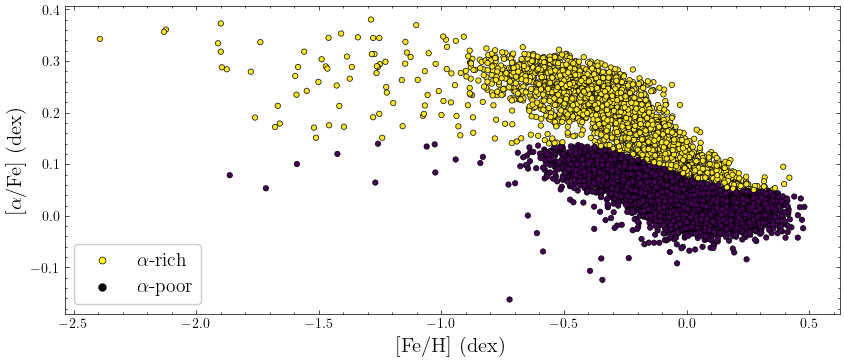

In [3]:
fig = plt.figure(figsize=(10, 4))
alf_c = [1 if alp == 'Arich' else 0 for alp in apo.alphaCat.values]
plt.scatter(apo['Fe/H'], apo['a/Fe'], c=alf_c, s=15, lw=0.5, edgecolor='k')
plt.xlabel('[Fe/H] (dex)', fontsize=fs); plt.ylabel('[$\\alpha$/Fe] (dex)', fontsize=fs)
plt.scatter([], [], c='yellow', s=25, edgecolor='k', label='$\\alpha$-rich', lw=0.5)
plt.scatter([], [], c='black', s=25, edgecolor='k', label='$\\alpha$-poor')
plt.legend(loc='lower left', prop={'size': fs-1}, frameon=True, framealpha=1); plt.show()

```{admonition} Understanding of abundances
:class: note
Where does the Sun fall in the [$\alpha$-Fe]-[Fe/H] diagram above? Would it be categorized as `Arich` or `Apoor`?
```

```{admonition} Chemical Evolution of the Milky Way
:class: seealso

The [$\alpha$-Fe] and [Fe/H] abundances of other stars relative to the Sun trace the history of stellar populations in the Milky Way. The most massive stars early in the history of the Galaxy were the first to live out their lifespans, ending with **type II supernovae** (type II SNe) that ejects an $\alpha$-element rich envelope into the interstellar medium, leaving behind a neutron star or black hole remnant core.

Type Ia supernovae (type Ia SNe), on the other hand, occurs from the thermonuclear explosion of a white dwarf in a binary system, **at timescales much longer compared to type II SNe**. Here, a runaway fusion reaction occurs within the carbon and oxygen core of a white dwarf. This yields **iron-peak nuclei** and releases enormous amounts energy that detonates the white dwarf's core.

Over time, these two processes are thought to form major pathways to the abundance patterns in Galactic stellar populations seen today.


```{figure} images/gal2.png
---
height: 370px
width: 850px
name: gal2
---
A cartoon schematic depicting the role of type Ia and type II supernovae in the patterns observed in the [$\alpha$-Fe]-[Fe/H] diagram. Adapted from [Chiappini (2001).](https://sites.astro.caltech.edu/~george/ay20/Chiappini-MilkyWay.pdf)

```
## Age prediction with Gradient Boosted Trees

In this notebook, we will predict the ages of the giant star with the catalog data at hand using Gradient Boosted Trees (GBTs). GBTs are popular in astronomical catalog analysis for a variety of reasons, including the following:


- **Nonlinear Modeling**: The relationship between observable properties and stellar age is often highly nonlinear and interaction-rich. GBTs can model complexities and intricate patterns within features that linear models typically miss.

- **High Predictive Performance**: GBTs generally perform strongly as out-of-the-box models, offering strong generalization with relatively few hyperparameters to tune.

- **Robustness to Feature Scaling and Outliers**: Unlike neural networks or regression models, GBTs do not require feature normalization. Similar to Random Forests, the tree-based splitting approach of GBTs to optimize their objective make them relatively robust to outliers.

- **Model Interpretability**: Modern GBT implementations provide tools (e.g. feature importances, SHAP values) that help quantify which features most strongly influence outputs, providing a convenient way to diagnose key quantities for scientific prediction tasks.

- **Improvement Over Random Forests**: While Random Forests (e.g., as shown in [](content:references:tabular_part1)) use **bagging** (building trees in parallel on bootstrapped samples), GBTs use **boosting**, where each tree corrects the errors of its predecessor. This sequential refinement enables GBTs to better capture subtle trends and achieve higher accuracy, particularly in structured datasets like stellar catalogs.



```{admonition} Gradient Boosting
:class: note
Boosting combines many **weak learners** -- typically shallow decision trees -- into a strong predictive model. Unlike *bagging* (e.g., Random Forests), where trees are trained independently and in parallel, boosting builds trees **sequentially**, each one attempting to correct the errors of its predecessors. 

As opposed to classical boosting (e.g., AdaBoost), which re-weights the training data to emphasize misclassified examples, **gradient** boosting trains new trees to predict the **residuals** (or negative gradients) of a chosen loss function. These residual-predicting trees are then added—typically with a small learning rate—to the ensemble's cumulative prediction, progressively reducing the overall loss.

This process can be described iteratively as the following:

Denote:

- $ y_i $ = true target for the $ i $-th sample
- $ \hat{y}_i^{(t)} $ = prediction at iteration $ t $
- $ F^{(t)}(x) $ = ensemble prediction after $ t $ iterations

Beginning with $F^{(0)}(x) = \text{mean}(y)$, we perform the following over each iteration $t$:
1. Compute residuals.
> $r_i^{(t)} = y_i - F^{(t-1)}(x_i)$

2. Fit a decision tree $ h^{(t)}(x) $ to the residuals $r_i^{(t)}$.

3. Update the model.  
> $F^{(t)}(x) = F^{(t-1)}(x) + \eta \cdot h^{(t)}(x)$

Here, $ \eta \in (0,1] $ is the learning rate, controlling how much we trust each new tree. 

In summary, a new tree is trained to predict the **residuals** at each iteration, and the new tree’s predictions are added (with a small weight) to the ensemble's running total.

```

In this Section, we will use the construction a gradient boosting regressor using [`lightgbm`](https://lightgbm.readthedocs.io/en/latest/index.html), a popular gradient boosting library.

### Baseline prediction using continuous features

To begin, we will use basic, global spectroscopic information of the giant star dataset ($T_{\mathrm{eff}}$, $\log$ (g), [Fe/H]), which are readily available from most spectroscopic surveys. 


In [18]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

trainfeatures = ['Teff', 'logg', 'Fe/H']

continuous_df = apo[['Age'] + trainfeatures].copy().dropna()
continuous_df

,Age,Teff,logg,Fe/H
0,2.8815,4718.9233,2.5146,-0.2617
1,0.5842,4479.2246,2.1176,0.1609
2,2.6495,4910.6035,2.4510,-0.2652
3,9.0694,4194.4375,1.6949,-0.3017
4,5.8519,4621.9960,2.7732,0.2081
...,...,...,...,...
11442,15.6194,4319.3400,2.0897,0.2022
11443,8.1186,4592.0396,2.3738,0.0764
11444,7.6715,4645.3340,2.6086,-0.0631
11445,3.2902,4912.1650,2.4933,-0.1505


In [13]:
# Split dataframe into input and output 
y = continuous_df['Age']
X = continuous_df.drop(columns = 'Age')

# Split into train and test (80-20 split)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 42)

```{tip}
The `lightgbm` API is designed to be compatible with `scikit-learn`, which means you can train models using `.fit()` and access predictions with `.predict()`, just as you would with other `scikit-learn` estimators. This makes it easy to plug LightGBM into standard machine learning workflows.
```

In [37]:
model_lgb = lgb.LGBMRegressor()
model_lgb.fit(train_X, train_y,
             eval_metric='rmse', 
             eval_set=[(test_X, test_y)],
                 callbacks=[lgb.early_stopping(stopping_rounds=10), # Early stopping on validation set 
    ])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 8483, number of used features: 3
[LightGBM] [Info] Start training from score 5.774475
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[46]	valid_0's rmse: 3.04319	valid_0's l2: 9.26099


LGBMRegressor()

We will evaluate the performance of the regressor in predicting ages using the Root Mean Squared Error (RMSE) metric and by comparing the age predictions directly as shown in the left panel below. However, an equally informative metric for stellar ages would be the average **fractional error** in the predictions.

In [53]:
lgb_pred = model_lgb.predict(test_X)
lgb_rmse = np.sqrt(MSE(test_y, lgb_pred))
lgm_relerr = np.mean(100*( lgb_pred - test_y )/test_y)
lgb_rmse, lgm_relerr

(3.043188250503478, 37.184133898229774)

In [72]:
def compare_age_predictions(pred, truth, rmse, relerr):
    fig = plt.figure(figsize=(10, 4))
    ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
    ax1.scatter(truth, pred, color='royalblue', edgecolor='k', lw=0.25)
    ax2.scatter(truth, 100*(pred - truth)/truth, edgecolor='k', lw=0.25, color='royalblue')
    
    ax1.plot([-0.2, 16], [-0.2, 16], c='r', ls='--')
    ax2.axhline(y=0, c='r', ls='--')
    ax1.set_ylabel('Predicted Ages (Gyr)', fontsize=fs)
    ax2.set_ylabel('Fractional Error [Pred - Truth] (\%)', fontsize=fs)

    ax1.set_ylim(0, 15); ax2.set_ylim(-250, 250)
    ax1.set_title(f'RMSE: {rmse:.3f}')
    ax2.set_title(f'Mean Relative Error: {relerr:.1f}\%')
        
    for ax in [ax1, ax2]:
        ax.set_xlabel('Validation Ages (Gyr)', fontsize=fs)
        ax.set_xlim(0, 15)
        ax.tick_params(axis='both', labelsize=fs-3); 
    plt.tight_layout(w_pad = 2); plt.show()

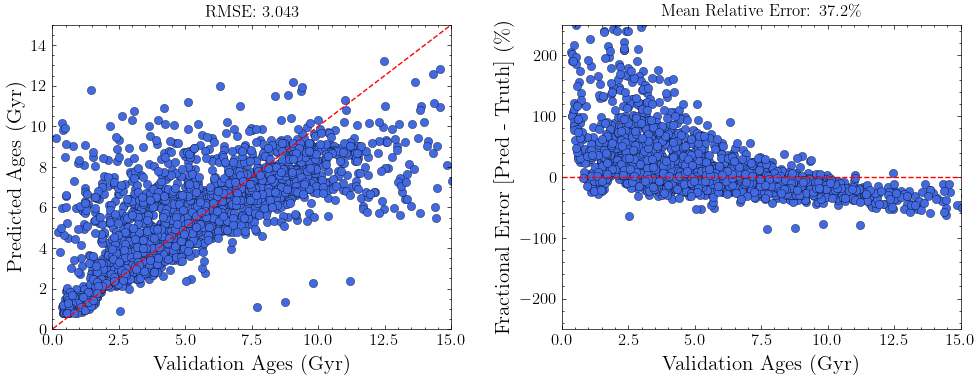

In [73]:
compare_age_predictions(lgb_pred, test_y, lgb_rmse, lgm_relerr)

The model clearly has skewed predictions, it is **overpredicting** at ages $<5\,$Gyr, while it is **underpredicting** the ages of old stars ($>10\,$Gyr). 

## Utilizing Categorical Data

As previously described, the categorical parameters `EV` and `alphaCat` may contain some useful correlations with age that can improve the performance of our gradient boosting model.

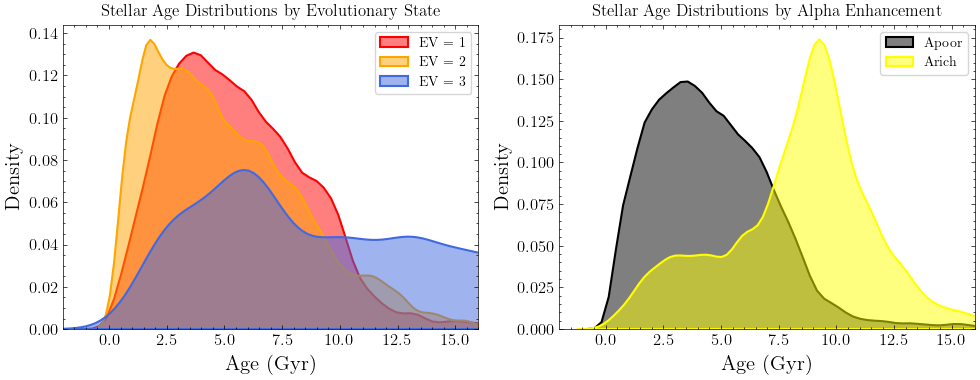

In [88]:
fig = plt.figure(figsize=(10, 4))

ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)

for ev_class, label, color in zip([1, 2, 3],
                                  ['EV = 1', 'EV = 2', 'EV = 3'],
                                  ['red', 'orange', 'royalblue']):
    sns.kdeplot(
        data=apo[apo['EV'] == ev_class],
        x='Age',
        fill=True,
        common_norm=False,
        alpha=0.5,
        linewidth=1.5,
        bw_adjust = 0.5,
        label=label,
        ax=ax1,
        color=color
    )

for alf_class, label, color in zip(['Apoor', 'Arich'],
                                  ['Apoor', 'Arich'],
                                  ['black', 'yellow']):
    sns.kdeplot(
        data=apo[apo['alphaCat'] == alf_class],
        x='Age',
        fill=True,
        common_norm=False,
        alpha=0.5,
        linewidth=1.5,
        bw_adjust = 0.5,
        label=label,
        ax=ax2,
        color=color
    )

ax1.set_title('Stellar Age Distributions by Evolutionary State')
ax2.set_title('Stellar Age Distributions by Alpha Enhancement')

for ax in [ax1, ax2]:
    ax.set_xlabel('Age (Gyr)', fontsize=fs)
    ax.set_ylabel('Density', fontsize=fs)
    ax.legend(frameon=True)
    ax.set_xlim(-2, 16)
    ax.tick_params(axis='both', labelsize=fs-3)

plt.tight_layout()
plt.show()

### One Hot Encoding

To utilize the categorical variables at hand, one direct approach is to **one-hot encode** these variables, for instance using `scikit-learn`'s `OneHotEncoder` method:

In [104]:
from sklearn.preprocessing import OneHotEncoder

def encode_columns(df, colname):
    
    ### Returns a copy of the original DataFrame with one hot encoded columns ###
    
    encoder = OneHotEncoder(sparse_output=False)
    ev_encoded = encoder.fit_transform(df[[colname]])
    encoded_cols = encoder.get_feature_names_out([colname])
    encoded_df = pd.DataFrame(ev_encoded, columns=encoded_cols, index=df.index)
    apo_ev_encoded = pd.concat([df, encoded_df], axis=1)

    return apo_ev_encoded  

apo_oh_encoded = encode_columns(apo, 'EV')
apo_oh_encoded = encode_columns(apo_oh_encoded, 'alphaCat')
apo_oh_encoded

,KIC,EV,a/Fe,Teff,Fe/H,logg,alphaCat,Age,EV_1,EV_2,EV_3,alphaCat_Apoor,alphaCat_Arich,alphaCat_nan
0,893214,1,0.0815,4718.9233,-0.2617,2.5146,Apoor,2.8815,1.0,0.0,0.0,1.0,0.0,0.0
1,1026309,1,-0.0295,4479.2246,0.1609,2.1176,Apoor,0.5842,1.0,0.0,0.0,1.0,0.0,0.0
2,1026452,2,0.0658,4910.6035,-0.2652,2.4510,Apoor,2.6495,0.0,1.0,0.0,1.0,0.0,0.0
3,1027110,1,0.2615,4194.4375,-0.3017,1.6949,Arich,9.0694,1.0,0.0,0.0,0.0,1.0,0.0
4,1027337,1,0.0354,4621.9960,0.2081,2.7732,Apoor,5.8519,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11442,12785401,1,0.0451,4319.3400,0.2022,2.0897,Apoor,15.6194,1.0,0.0,0.0,1.0,0.0,0.0
11443,12833300,2,0.0741,4592.0396,0.0764,2.3738,Arich,8.1186,0.0,1.0,0.0,0.0,1.0,0.0
11444,12884116,1,0.0762,4645.3340,-0.0631,2.6086,Apoor,7.6715,1.0,0.0,0.0,1.0,0.0,0.0
11445,12884930,2,0.0384,4912.1650,-0.1505,2.4933,Apoor,3.2902,0.0,1.0,0.0,1.0,0.0,0.0


We proceed the same way as before, but now using the one-hot encoded columns as input features.

In [106]:
trainfeatures = ['Teff', 'logg', 'Fe/H', 'EV_1', 'EV_2', 'EV_3', 'alphaCat_Apoor',
                'alphaCat_Arich'] # new train features

onehotev_df = apo_oh_encoded[['Age'] + trainfeatures].copy().dropna()

# Split dataframe into input and output 
y = onehotev_df['Age']
X = onehotev_df.drop(columns = 'Age')

# Split into train and test (80-20 split)
onehotev_train_X, onehotev_test_X, onehotev_train_y,\
onehotev_test_y = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Initialize a new lightgbm model and train on the one hot ev dataset ##
model_lgb = lgb.LGBMRegressor()
model_lgb.fit(onehotev_train_X, onehotev_train_y,
             eval_metric='rmse', 
             eval_set=[(onehotev_test_X, onehotev_test_y)],
                 callbacks=[lgb.early_stopping(stopping_rounds=10), # Early stopping on validation set 
    ])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 775
[LightGBM] [Info] Number of data points in the train set: 8483, number of used features: 8
[LightGBM] [Info] Start training from score 5.774475
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[55]	valid_0's rmse: 2.86185	valid_0's l2: 8.1902


LGBMRegressor()

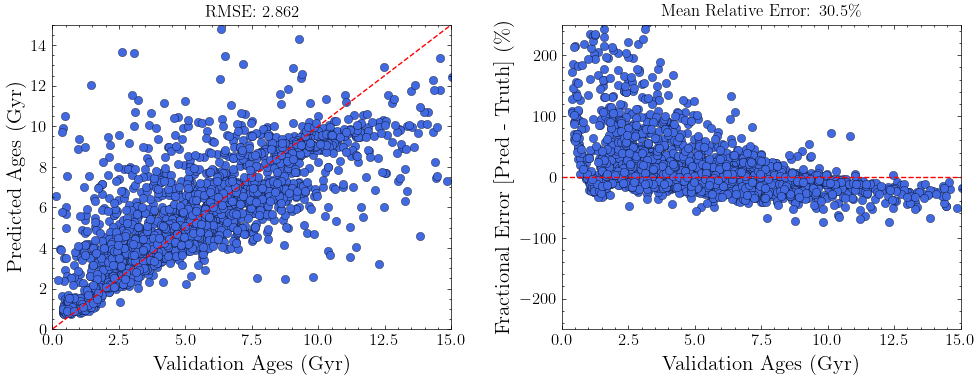

In [107]:
lgb_pred_onehotev = model_lgb.predict(onehotev_test_X)
lgb_rmse_onehotev = np.sqrt(MSE(onehotev_test_y, lgb_pred_onehotev))
lgm_relerr_onehotev = np.mean(100*( lgb_pred_onehotev - onehotev_test_y )/onehotev_test_y)

compare_age_predictions(lgb_pred_onehotev, onehotev_test_y, lgb_rmse_onehotev, lgm_relerr_onehotev)

### Native Encoding Approach

Another way would be to use `lightgbm`'s native encoding approach, which provides the option to handle categorical variables without the need of one hot encoding.


```{admonition} lightgbm's native encoding
:class: note

LightGBM does **not** split on individual category values or expand them via one-hot encoding. Instead, it evaluates **partitions of category values** into two subsets (left vs. right in the tree).

Naively, if a categorical feature has $k$ unique values, there are $2^{(k - 1)} - 1$ ways to partition them. Exhaustively testing all is computationally infeasible.

However, LightGBM uses an [efficient approximation](https://lightgbm.readthedocs.io/en/latest/Features.html#optimal-split-for-categorical-features) during training:

- For each tree node, it computes the **sum of gradients and Hessians** for each category.
- It then **sorts the categories** by their **gradient statistics**:  
  $\frac{\text{sum of gradients}}{\text{sum of Hessians}}$  
  (a proxy for how predictive each category is).
- Once ordered, it performs a sequential scan over the sorted sequence to find the best binary split (i.e., optimal threshold in the category order).

This reduces complexity from $\mathcal{O}(2^k)$ to $\mathcal{O}(k \log k)$, allowing LightGBM to handle high-cardinality categorical features efficiently and robustly.
```

Note that `lightgbm` does **not** automatically handle string-based categorical features. They must either be converted to integer codes or explicitly cast to the category data type in `pandas`, which `lightgbm` will recognize and treat accordingly during training.


In [151]:
trainfeatures = ['Teff', 'logg', 'Fe/H', 'EV', 'alphaCat']

train_df = apo[['Age'] + trainfeatures].copy().dropna()

# Split dataframe into input and output 
y = train_df['Age']
X = train_df.drop(columns = 'Age')

# Split into train and test (80-20 split)
train_X, test_X, train_y,\
test_y = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train_lgb = train_X.copy()
X_train_lgb['alphaCat'] = X_train_lgb['alphaCat'].astype('category')

X_test_lgb = test_X.copy()
X_test_lgb['alphaCat'] = X_test_lgb['alphaCat'].astype('category')

In [124]:
model_lgb = lgb.LGBMRegressor()
model_lgb.fit(X_train_lgb, train_y,
             eval_metric='rmse', 
             eval_set=[(X_test_lgb, test_y)],
                 callbacks=[lgb.early_stopping(stopping_rounds=10), # Early stopping on validation set 
    ])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 772
[LightGBM] [Info] Number of data points in the train set: 8483, number of used features: 5
[LightGBM] [Info] Start training from score 5.774475
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[55]	valid_0's rmse: 2.86185	valid_0's l2: 8.1902


LGBMRegressor()

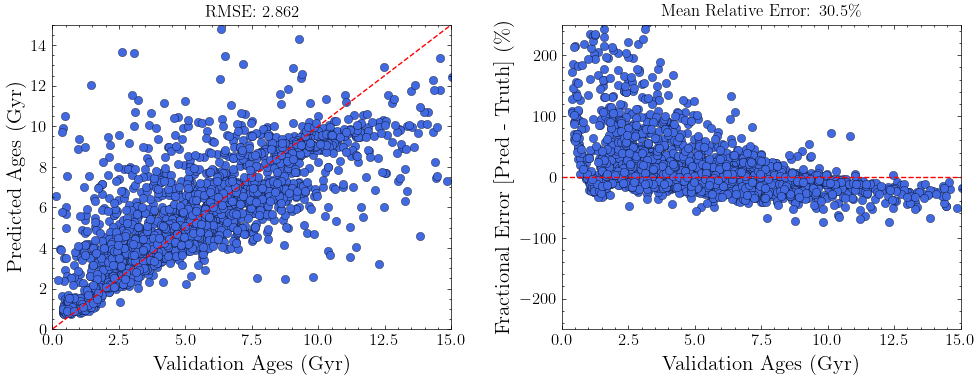

In [122]:
lgb_pred = model_lgb.predict(X_test_lgb)
lgb_rmse = np.sqrt(MSE(test_y, lgb_pred))
lgm_relerr = np.mean(100*( lgb_pred - test_y )/test_y)

compare_age_predictions(lgb_pred, test_y, lgb_rmse, lgm_relerr)

We see that there is no difference between the one hot encoding case and the native encoding case!


```{admonition} Interpreting the Similarity of Results across Encodings
:class: note

Depending on the application, the performance of `lightgbm` with native categorical encoding may not differ significantly from standard one-hot encoding.

### **Low Cardinality Categorical Feature**

When a categorical feature has only a few distinct values (e.g. three classes: 0, 1, 2), the number of distinct binary partitions `lightgbm` could explore is small. For $k$ categories, `lightgbm` may consider up to $2^{k-1} - 1$ partitions. So for $k = 3$, only **3** non-trivial partitions exist. In this setting:

- One-hot encoding effectively separates the classes across orthogonal binary axes.
- Native encoding does the same by finding the optimal category grouping at a node. However, **for only 3 categories, the set of possibilities is limited**.

Thus, both approaches may lead to similar decision splits in this scenario.

---

### **Low Predictive Power of the Categorical Feature**

If the categorical feature contributes very little to reducing the loss (e.g. it has weak or no correlation with the target), then:

- The model rarely chooses this feature to split on regardless of encoding.
- Feature importances (e.g. based on split count or gain) for this feature will be low or zero.
- The resulting predictions will be nearly identical whether one-hot encoding or native encoding is used.

In this case, the model's performance is **dominated by other, more informative features**, and the encoding method has negligible effect.

---

Let's visualize the feature importances using `lightgbm`'s built-in method. Evidently, the categorical features, while useful in providing a performance boost, are not as informative as the other global spectroscopic parameters.

In [150]:
for col, num_splits in zip(X_test_lgb.columns, model_lgb.feature_importances_):
    print(f'Column "{col}" was chosen {num_splits} times to create a decision split.')

Column "Teff" was chosen 505 times to create a decision split.
Column "logg" was chosen 549 times to create a decision split.
Column "Fe/H" was chosen 454 times to create a decision split.
Column "EV" was chosen 88 times to create a decision split.
Column "alphaCat" was chosen 54 times to create a decision split.


```{admonition} Exercise: Comparing Gradient Boosting Libraries
:class: note

There are many modern implementations of gradient boosting decision trees, including [**CatBoost** developed by Yandex](https://catboost.ai/). Unlike `lightgbm` or `xgboost`, which typically require categorical variables to be integer-encoded or one-hot encoded, CatBoost natively handles **string-based** or **categorical** features. It uses a special **ordered target-based encoding** that preserves training integrity by avoiding data leakage — making it especially well-suited for **mixed-type datasets**.

In this exercise, you'll explore the use of the CatBoost library.

---

**Tasks:**

1. Use `CatBoostRegressor` to train a model using the **native categorical feature handling**:
   - Provide the categorical feature names via the `cat_features` argument. By design, this is handled even more elegantly compared to `lightgbm`:
   >
   >
   > 
2. Compare this to a model trained using **one-hot encoding** on the same features (e.g., using `sklearn.preprocessing.OneHotEncoder`).

3. Calculate feature importances from the CatBoost model using their [in-built approaches](https://catboost.ai/docs/en/features/feature-importances-calculation).

---

- Does CatBoost’s native encoding improve performance?
- Are there trade-offs in training time or performance?
- Do the CatBoost feature importances provide the same conclusion as the one obtained by `lightgbm` above?
